In [3]:
!pip install boto3
import copy
import os
import boto3
import traceback
import io
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from botocore.exceptions import ClientError, NoCredentialsError
from traceback import format_exc

os.environ['AWS_ACCESS_KEY_ID'] = <access_key>
os.environ['AWS_SECRET_ACCESS_KEY'] = <secret_access_key>

BUCKET = 'russian-stocks-quotes'

access_key = os.getenv('AWS_ACCESS_KEY_ID')
secret_key = os.getenv('AWS_SECRET_ACCESS_KEY')
endpoint_url = 'https://storage.yandexcloud.net'

# Создание клиента S3
s3_client = boto3.client('s3',
                         region_name='ru-central1',
                         aws_access_key_id=access_key,
                         aws_secret_access_key=secret_key,
                         endpoint_url=endpoint_url)

def upload_object_to_s3(key, body):
    response = s3_client.put_object(Bucket=BUCKET, Key=key, Body=body)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно сохранен в {BUCKET}/{key}")
    else:
        print(f"Ошибка при сохранении: {response['ResponseMetadata']['HTTPStatusCode']}")

def upload_data_frame_to_s3(secid, data_frame, dir):
    pickle_buffer = io.BytesIO()
    data_frame.to_pickle(pickle_buffer)
    pickle_buffer.seek(0)
    data_frame_file = f'{dir}secids/{secid}/{secid}_data_frame.pkl'
    upload_object_to_s3(data_frame_file, pickle_buffer)

def upload_info_to_s3(secid, info, dir):
    info['miss_index'] = info['miss_index'].to_numpy().tolist()
    json_data = json.dumps(info)
    info_file = f'{dir}secids/{secid}/{secid}_info.pkl'
    upload_object_to_s3(info_file, json_data)

def upload_secid_names(dict_data, dir):
    json_data = json.dumps(list(dict_data.keys()))
    secid_names_file = f'{dir}secid_names.pkl'
    upload_object_to_s3(secid_names_file, json_data)

def upload_data_to_s3(dict_data, dir):
    try:
        upload_secid_names(dict_data, dir)
        for secid, data in dict_data.items():
            copy_data = copy.deepcopy(data)
            upload_data_frame_to_s3(secid, copy_data['data_frame'], dir)
            del copy_data['data_frame']
            upload_info_to_s3(secid, copy_data, dir)
    except ClientError as e:
        print(f"Произошла ошибка: {e.response['Error']['Message']}")
    except Exception as e:
        error_message = f"Неизвестная ошибка: {str(e)}"
        error_context = traceback.format_exc()
        print(f"{error_message}\nКонтекст ошибки:\n{error_context}")

def list_directories(s3_client):
    directories = set()
    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        for page in paginator.paginate(Bucket=BUCKET, Delimiter='/'):
            for prefix in page.get('CommonPrefixes', []):
                directories.add(prefix.get('Prefix'))
    except NoCredentialsError:
        print("Ошибка: Неверные учетные данные.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    return directories

def download_object_from_s3(key):
    response = s3_client.get_object(Bucket=BUCKET, Key=key)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно получен из {BUCKET}/{key}")
    else:
        print(f"Ошибка при получении: {response['ResponseMetadata']['HTTPStatusCode']}")
    return response['Body'].read()

def download_info_from_s3(dir, secid):
    key = f'{dir}secids/{secid}/{secid}_info.pkl'
    response = download_object_from_s3(key)
    data = json.loads(response)
    data['miss_index'] = pd.Index(np.array(data['miss_index']))
    return data

def download_data_frame_from_s3(dir, secid):
    key = f'{dir}secids/{secid}/{secid}_data_frame.pkl'
    response = download_object_from_s3(key)
    buffer = io.BytesIO(response)
    data = pd.read_pickle(buffer)
    data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'])
    return data

def download_secid_names(dir):
    key = f'{dir}secid_names.pkl'
    return json.loads(download_object_from_s3(key))

def download_data_from_s3(dir, secids=None):
    data = {}
    try:
        directories = download_secid_names(dir)
        for secid in directories:
            if secids is None or secid in secids:
                if secids is not None:
                    secids.remove(secid)
                data[secid] = download_info_from_s3(dir, secid)
                data[secid]['data_frame'] = download_data_frame_from_s3(dir, secid)
    except Exception as e:
        error_message = f"Неизвестная ошибка: {str(e)}"
        error_context = traceback.format_exc()
        print(f"{error_message}\nКонтекст ошибки:\n{error_context}")
    if secids is not None and len(secids) > 0:
        print(f'Не нашли {secids}')
    return data

Ridge Regression

In [18]:
import pickle

secid = 'ALRS'
model_name = 'ridge'
def download_models_data_from_s3(secid, model_name):
    key = f'predictions/{secid}/{model_name}.pkl'
    print(key)
    response = s3_client.get_object(Bucket=BUCKET, Key=key)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешное получение в {BUCKET}/{key}")
        return pickle.loads(response['Body'].read())
    else:
        print(f"Ошибка при получение: {response['ResponseMetadata']['HTTPStatusCode']}")

fitted_model = download_models_data_from_s3(secid, model_name)
fitted_model

predictions/ALRS/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ALRS/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'name': 'ridge',
 'model': Ridge(),
 'grid_params': {'random_state': [42],
  'alpha': array([1.00000000e-04, 1.00184395e-04, 1.00369130e-04, ...,
         9.96322275e+03, 9.98159444e+03, 1.00000000e+04]),
  'fit_intercept': [True, False]},
 'importances_name': 'coef_',
 'predictions': [np.float64(63.08604150270359),
  np.float64(63.06772993373818),
  np.float64(63.13950997763638),
  np.float64(63.244015730835436),
  np.float64(63.191969199198134),
  np.float64(63.14646741598718),
  np.float64(63.123426569820865),
  np.float64(63.03743760285597),
  np.float64(62.947836431747845),
  np.float64(62.965338027268004),
  np.float64(63.08533470225909),
  np.float64(63.25070457593057),
  np.float64(63.36935449231305),
  np.float64(63.50649166765485),
  np.float64(63.635908529905294),
  np.float64(63.76798108754547),
  np.float64(63.889435903487225),
  np.float64(63.96341218926283),
  np.float64(64.0242244761547),
  np.float64(64.08277916021842),
  np.float64(64.19600410889488),
  np.float64(64

In [17]:
def download_data_frame_from_s3(secid):
    key = f'preprocessed_data/secids/{secid}/{secid}_data_frame.pkl'
    response = s3_client.get_object(Bucket=BUCKET, Key=key)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешное получение в {BUCKET}/{key}")
        return pickle.loads(response['Body'].read())
    else:
        print(f"Ошибка при получение: {response['ResponseMetadata']['HTTPStatusCode']}")

data_frame = download_data_frame_from_s3(secid)
data_frame['CLOSE'][int(len(data_frame) * 0.8):]

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ABIO/ABIO_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


,CLOSE
248,84.24
249,83.84
250,84.94
251,86.94
252,83.98
...,...
306,84.10
307,81.50
308,80.76
309,87.88


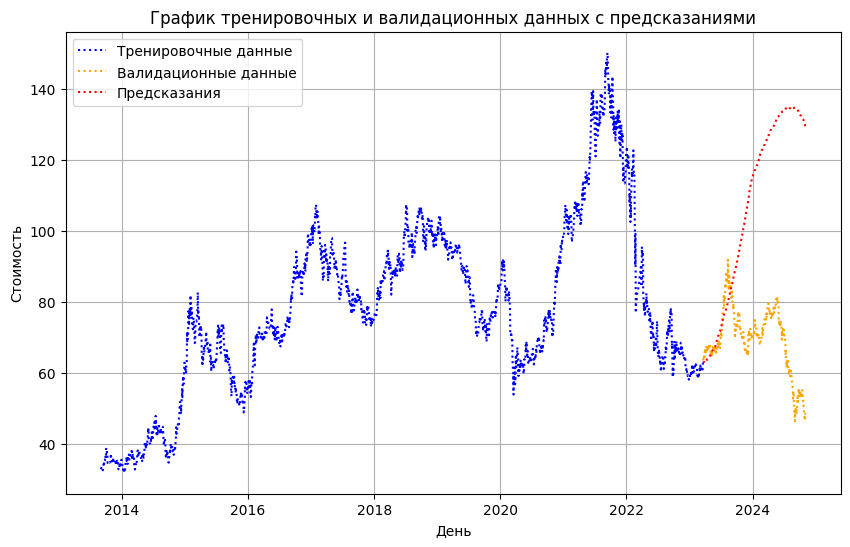

In [6]:
from io import BytesIO

plt.figure(figsize=(10, 6))

train = data_frame.iloc[:len(data_frame) - len(fitted_model['predictions'])]
val = data_frame.iloc[len(data_frame) - len(fitted_model['predictions']):]
# Тренировочные данные
plt.plot(pd.to_datetime(train['TRADEDATE']), train['CLOSE'], ':', color='blue', label='Тренировочные данные')

# Валидационные данные
plt.plot(pd.to_datetime(val['TRADEDATE']), val['CLOSE'], ':', color='orange', label='Валидационные данные')

# Предсказания
plt.plot(pd.to_datetime(val['TRADEDATE']), fitted_model['predictions'], ':', color='red', label='Предсказания')

# Настройка графика
plt.title('График тренировочных и валидационных данных с предсказаниями')
plt.xlabel('День')
plt.ylabel('Стоимость')
plt.legend()
plt.grid(True)

# Показать график
plt.show()
# img_buffer = BytesIO()
# plt.savefig(img_buffer, format='png')
# img_buffer.seek(0)
# plt.close()
# s3_client.put_object(Bucket=BUCKET, Key= f'predictions/{secid}/images/{model_name}_image.png', Body=img_buffer)

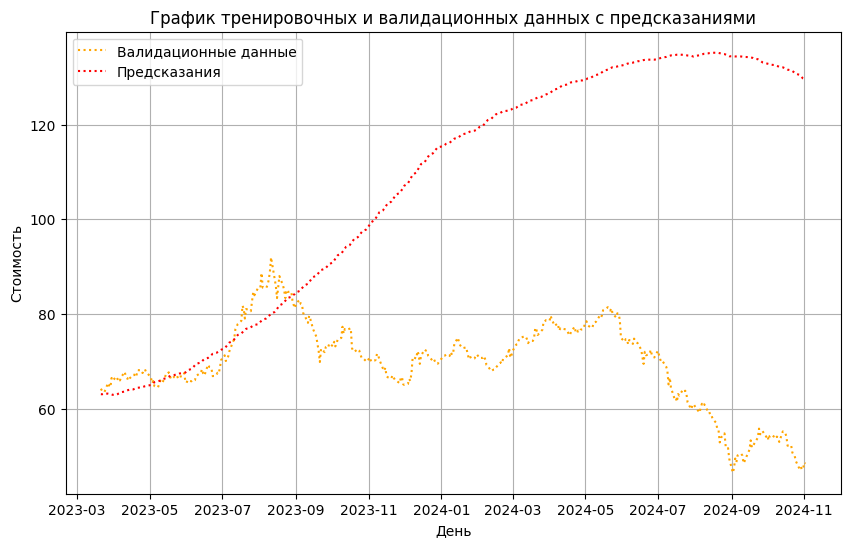

In [7]:
plt.figure(figsize=(10, 6))

val = data_frame.iloc[len(data_frame) - len(fitted_model['predictions']):]
# Валидационные данные
plt.plot(pd.to_datetime(val['TRADEDATE']), val['CLOSE'], ':', color='orange', label='Валидационные данные')

# Предсказания
plt.plot(pd.to_datetime(val['TRADEDATE']), fitted_model['predictions'], ':', color='red', label='Предсказания')

# Настройка графика
plt.title('График тренировочных и валидационных данных с предсказаниями')
plt.xlabel('День')
plt.ylabel('Стоимость')
plt.legend()
plt.grid(True)

# Показать график
plt.show()

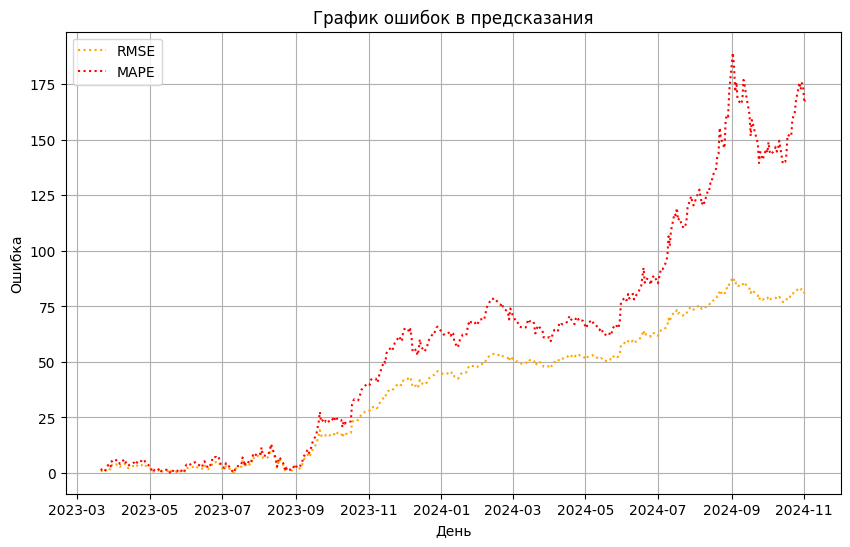

In [8]:
rmse = list()
mape = list()
for metrics in fitted_model['metric_scores']:
  rmse.append(metrics['rmse'])
  mape.append(metrics['mape'])


plt.figure(figsize=(10, 6))

# Валидационные данные
plt.plot(pd.to_datetime(val['TRADEDATE']), rmse, ':', color='orange', label='RMSE')

# Предсказания
plt.plot(pd.to_datetime(val['TRADEDATE']), mape, ':', color='red', label='MAPE')

# Настройка графика
plt.title('График ошибок в предсказания')
plt.xlabel('День')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True)

# Показать график
plt.show()

In [22]:
def list_directories(s3_client):
    directories = set()
    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        for page in paginator.paginate(Bucket=BUCKET, Delimiter='/', Prefix='predictions/'):
            for prefix in page.get('CommonPrefixes', []):
                directories.add(prefix.get('Prefix').split('/')[-2])
    except NoCredentialsError:
        print("Ошибка: Неверные учетные данные.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    return directories

secids = sorted(list(list_directories(s3_client)))
secids.remove('images')

In [10]:
def save_graph_cost(data_frame, fitted_model, secid, model_name):
  plt.figure(figsize=(10, 6))

  train = data_frame.iloc[:len(data_frame) - len(fitted_model['predictions'])]
  val = data_frame.iloc[len(data_frame) - len(fitted_model['predictions']):]
  # Тренировочные данные
  plt.plot(pd.to_datetime(train['TRADEDATE']), train['CLOSE'], ':', color='blue', label='Тренировочные данные')

  # Валидационные данные
  plt.plot(pd.to_datetime(val['TRADEDATE']), val['CLOSE'], ':', color='orange', label='Валидационные данные')

  # Предсказания
  plt.plot(pd.to_datetime(val['TRADEDATE']), fitted_model['predictions'], ':', color='red', label='Предсказания')

  # Настройка графика
  plt.title(f'График тренировочных и валидационных данных с предсказаниями для {secid}')
  plt.xlabel('День')
  plt.ylabel('Стоимость')
  plt.legend()
  plt.grid(True)

  # Сохранить график
  img_buffer = BytesIO()
  plt.savefig(img_buffer, format='png')
  img_buffer.seek(0)
  plt.close()
  s3_client.put_object(Bucket=BUCKET, Key= f'predictions/{secid}/images/{model_name}_cost.png', Body=img_buffer)

def save_graph_val_cost(data_frame, fitted_model, secid, model_name):
  val = data_frame.iloc[len(data_frame) - len(fitted_model['predictions']):]

  for name, days_count in { 'week': 5, 'month': 21, 'year': 247, 'maximum': 999999999}.items():
    if len(val['CLOSE']) < days_count and name != 'maximum':
      continue
    limit = min(len(val['CLOSE']), days_count)
    plt.figure(figsize=(10, 6))

    # Валидационные данные
    plt.plot(pd.to_datetime(val['TRADEDATE'][:limit]), val['CLOSE'][:limit], ':', color='orange', label='Валидационные данные')

    # Предсказания
    plt.plot(pd.to_datetime(val['TRADEDATE'][:limit]), fitted_model['predictions'][:limit], ':', color='red', label='Предсказания')

    # Настройка графика
    plt.title(f'График валидационных данных с предсказаниями для {secid}')
    plt.xlabel('День')
    plt.ylabel('Стоимость')
    plt.legend()
    plt.grid(True)

    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)
    plt.close()
    s3_client.put_object(Bucket=BUCKET, Key= f'predictions/{secid}/images/{model_name}_val_cost_{name}.png', Body=img_buffer)

def save_graph_errors(data_frame, fitted_model, secid, model_name, error, error_name):
  val = data_frame.iloc[len(data_frame) - len(fitted_model['predictions']):]

  for name, days_count in { 'week': 5, 'month': 21, 'year': 247, 'maximum': 999999999}.items():
    if len(val['CLOSE']) < days_count and name != 'maximum':
      continue
    limit = min(len(val['CLOSE']), days_count)
    plt.figure(figsize=(10, 6))
    plt.plot(pd.to_datetime(val['TRADEDATE'][:limit]), error[:limit], ':', color='red', label=error_name)

    # Настройка графика
    plt.title(f'График ошибок в предсказаниях для {secid}')
    plt.xlabel('День')
    plt.ylabel('Ошибка')
    plt.legend()
    plt.grid(True)

    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)
    plt.close()
    s3_client.put_object(Bucket=BUCKET, Key= f'predictions/{secid}/images/{model_name}_{error_name}_errors_{name}.png', Body=img_buffer)

def save_graph_mean_errors(model_name, error, error_name):
  for name, days_count in { 'week': 5, 'month': 21, 'year': 247, 'maximum': 999999999}.items():
    if len(val['CLOSE']) < days_count and name != 'maximum':
      continue
    limit = min(len(val['CLOSE']), days_count)

    plt.figure(figsize=(10, 6))

    plt.plot(list(range(1, limit + 1)), error[:limit], ':', color='red', label=error_name)

    # Настройка графика
    plt.title('График средних ошибок в предсказаниях')
    plt.xlabel('День')
    plt.ylabel('Ошибка')
    plt.legend()
    plt.grid(True)

    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)
    plt.close()
    s3_client.put_object(Bucket=BUCKET, Key= f'predictions/images/{model_name}_{error_name}_mean_errors_{name}.png', Body=img_buffer)

def save_graph_best_worse(error, error_name, tonality):
  for name, days_count in { 'week': 5, 'month': 21, 'year': 247, 'maximum': 999999999}.items():
    if len(val['CLOSE']) < days_count and name != 'maximum':
      continue
    limit = min(len(val['CLOSE']), days_count)
    plt.figure(figsize=(10, 6))
    plt.plot(list(range(1, limit + 1)), error[:limit], ':', color='red', label=error_name)

    # Настройка графика
    plt.title(f'График {"лучших" if tonality == "best" else "худших"} ошибок в предсказаниях')
    plt.xlabel('День')
    plt.ylabel('Ошибка')
    plt.legend()
    plt.grid(True)

    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)
    plt.close()
    s3_client.put_object(Bucket=BUCKET, Key= f'predictions/images/{tonality}_{error_name}_errors_{name}.png', Body=img_buffer)

def upload_errors_data(data, error_name):
    json_data = json.dumps(data)
    error_name_file = f'predictions/{error_name}.pkl'
    upload_object_to_s3(error_name_file, json_data)

In [ ]:
model_names = ['random_forest', 'ridge']
best_rmse = list()
best_mape = list()
worse_rmse = list()
worse_mape = list()
for model_name in model_names:
  rmse_data = list()
  mape_data = list()
  for secid in secids:
    fitted_model = download_models_data_from_s3(secid, model_name)
    data_frame = download_data_frame_from_s3(secid)
    save_graph_cost(data_frame, fitted_model, secid, model_name)
    save_graph_val_cost(data_frame, fitted_model, secid, model_name)
    rmse = list()
    mape = list()
    for metrics in fitted_model['metric_scores']:
      rmse.append(metrics['rmse'])
      mape.append(metrics['mape'])
    save_graph_errors(data_frame, fitted_model, secid, model_name, rmse, 'RMSE')
    save_graph_errors(data_frame, fitted_model, secid, model_name, mape, 'MAPE')
    for indx in range(len(rmse)):
      if len(rmse_data) > indx:
        rmse_data[indx] += rmse[indx]
      else:
        rmse_data.append(rmse[indx])

      if len(best_rmse) > indx:
        if best_rmse[indx]['value'] > rmse[indx]:
          best_rmse[indx] = { 'value': rmse[indx], 'secid': secid, 'model': model_name }
      else:
        best_rmse.append({ 'value': rmse[indx], 'secid': secid, 'model': model_name })

      if len(worse_rmse) > indx:
        if worse_rmse[indx]['value'] < rmse[indx]:
          worse_rmse[indx] = { 'value': rmse[indx], 'secid': secid, 'model': model_name }
      else:
        worse_rmse.append({ 'value': rmse[indx], 'secid': secid, 'model': model_name })

      if len(mape_data) > indx:
        mape_data[indx] += mape[indx]
      else:
        mape_data.append(mape[indx])

      if len(best_mape) > indx:
        if best_mape[indx]['value'] > mape[indx]:
          best_mape[indx] = { 'value': mape[indx], 'secid': secid, 'model': model_name }
      else:
        best_mape.append({ 'value': mape[indx], 'secid': secid, 'model': model_name })

      if len(worse_mape) > indx:
        if worse_mape[indx]['value'] < mape[indx]:
          worse_mape[indx] = { 'value': mape[indx], 'secid': secid, 'model': model_name }
      else:
        worse_mape.append({ 'value': mape[indx], 'secid': secid, 'model': model_name })

  for indx in range(len(rmse_data)):
    rmse_data[indx] /= len(secids)

  for indx in range(len(mape_data)):
    mape_data[indx] /= len(secids)

  save_graph_mean_errors(model_name, rmse_data, 'RMSE')
  save_graph_mean_errors(model_name, mape_data, 'MAPE')

upload_errors_data(best_rmse, 'best_rmse')
upload_errors_data(best_mape, 'best_mape')
upload_errors_data(worse_rmse, 'worse_rmse')
upload_errors_data(worse_mape, 'worse_mape')
save_graph_best_worse([item['value'] for item in best_rmse], 'RMSE', 'best')
save_graph_best_worse([item['value'] for item in best_mape], 'MAPE', 'best')
save_graph_best_worse([item['value'] for item in worse_rmse], 'RMSE', 'worse')
save_graph_best_worse([item['value'] for item in worse_mape], 'MAPE', 'worse')

predictions/ABIO/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ABIO/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ABIO/ABIO_data_frame.pkl
predictions/AFKS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/AFKS/random_forest.pkl
Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AFKS/AFKS_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AFLT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/AFLT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AFLT/AFLT_data_frame.pkl
predictions/AGRO/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/AGRO/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AGRO/AGRO_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AKRN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/AKRN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AKRN/AKRN_data_frame.pkl
predictions/ALRS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ALRS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ALRS/ALRS_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AMEZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/AMEZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AMEZ/AMEZ_data_frame.pkl
predictions/APRI/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/APRI/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/APRI/APRI_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/APTK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/APTK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/APTK/APTK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AQUA/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/AQUA/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AQUA/AQUA_data_frame.pkl
predictions/ARMD/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ARMD/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ARMD/ARMD_data_frame.pkl
predictions/ARSA/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ARSA/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ARSA/ARSA_data_frame.pkl
predictions/ASTR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ASTR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ASTR/ASTR_data_frame.pkl
predictions/AVAZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/AVAZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AVAZ/AVAZ_data_frame.pkl
predictions/AVAZP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/AVAZP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AVAZP/AVAZP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/BANE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/BANE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BANE/BANE_data_frame.pkl
predictions/BANEP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/BANEP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BANEP/BANEP_data_frame.pkl
predictions/BELU/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/BELU/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BELU/BELU_data_frame.pkl
predictions/BLNG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/BLNG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BLNG/BLNG_data_frame.pkl
predictions/BRZL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/BRZL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BRZL/BRZL_data_frame.pkl
predictions/BSPB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/BSPB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BSPB/BSPB_data_frame.pkl
predictions/BSPBP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/BSPBP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BSPBP/BSPBP_data_frame.pkl
predictions/CARM/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/CARM/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CARM/CARM_data_frame.pkl
predictions/CBOM/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/CBOM/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CBOM/CBOM_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/CHMF/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/CHMF/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CHMF/CHMF_data_frame.pkl
predictions/CHMK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/CHMK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CHMK/CHMK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/CIAN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/CIAN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CIAN/CIAN_data_frame.pkl
predictions/CNTL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/CNTL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CNTL/CNTL_data_frame.pkl
predictions/CNTLP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/CNTLP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CNTLP/CNTLP_data_frame.pkl
predictions/DASB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DASB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DASB/DASB_data_frame.pkl
predictions/DATA/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DATA/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DATA/DATA_data_frame.pkl
predictions/DELI/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DELI/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DELI/DELI_data_frame.pkl
predictions/DIAS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DIAS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DIAS/DIAS_data_frame.pkl
predictions/DIOD/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DIOD/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DIOD/DIOD_data_frame.pkl
predictions/DIXY/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DIXY/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DIXY/DIXY_data_frame.pkl
predictions/DSKY/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DSKY/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DSKY/DSKY_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/DVEC/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DVEC/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DVEC/DVEC_data_frame.pkl
predictions/DZRDP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/DZRDP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DZRDP/DZRDP_data_frame.pkl
predictions/EELT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/EELT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/EELT/EELT_data_frame.pkl
predictions/ELFV/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ELFV/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ELFV/ELFV_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ELMT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ELMT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ELMT/ELMT_data_frame.pkl
predictions/ELTZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ELTZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ELTZ/ELTZ_data_frame.pkl
predictions/ENPG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ENPG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ENPG/ENPG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ENPL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ENPL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ENPL/ENPL_data_frame.pkl
predictions/ETLN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ETLN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ETLN/ETLN_data_frame.pkl
predictions/EUTR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/EUTR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/EUTR/EUTR_data_frame.pkl
predictions/FEES/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/FEES/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FEES/FEES_data_frame.pkl
predictions/FESH/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/FESH/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FESH/FESH_data_frame.pkl
predictions/FIXP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/FIXP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FIXP/FIXP_data_frame.pkl
predictions/FLOT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/FLOT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FLOT/FLOT_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/FTRE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/FTRE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FTRE/FTRE_data_frame.pkl
predictions/GAZA/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GAZA/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GAZA/GAZA_data_frame.pkl
predictions/GAZP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GAZP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GAZP/GAZP_data_frame.pkl
predictions/GCHE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GCHE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GCHE/GCHE_data_frame.pkl
predictions/GECO/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GECO/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GECO/GECO_data_frame.pkl
predictions/GEMA/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GEMA/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GEMA/GEMA_data_frame.pkl
predictions/GEMC/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GEMC/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GEMC/GEMC_data_frame.pkl
predictions/GLTR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GLTR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GLTR/GLTR_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GMKN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GMKN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GMKN/GMKN_data_frame.pkl
predictions/GRNT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GRNT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GRNT/GRNT_data_frame.pkl
predictions/GTLC/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GTLC/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GTLC/GTLC_data_frame.pkl
predictions/GTPR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GTPR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GTPR/GTPR_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GTRK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/GTRK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GTRK/GTRK_data_frame.pkl
predictions/HALS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/HALS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HALS/HALS_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/HEAD/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/HEAD/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HEAD/HEAD_data_frame.pkl
predictions/HHRU/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/HHRU/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HHRU/HHRU_data_frame.pkl
predictions/HMSG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/HMSG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HMSG/HMSG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/HNFG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/HNFG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HNFG/HNFG_data_frame.pkl
predictions/HYDR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/HYDR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HYDR/HYDR_data_frame.pkl
predictions/INGR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/INGR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/INGR/INGR_data_frame.pkl
predictions/IRAO/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/IRAO/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/IRAO/IRAO_data_frame.pkl
predictions/IRKT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/IRKT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/IRKT/IRKT_data_frame.pkl
predictions/IVAT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/IVAT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/IVAT/IVAT_data_frame.pkl
predictions/KBTK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KBTK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KBTK/KBTK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KLVZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KLVZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KLVZ/KLVZ_data_frame.pkl
predictions/KMAZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KMAZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KMAZ/KMAZ_data_frame.pkl
predictions/KMEZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KMEZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KMEZ/KMEZ_data_frame.pkl
predictions/KMTZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KMTZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KMTZ/KMTZ_data_frame.pkl
predictions/KRKNP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KRKNP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KRKNP/KRKNP_data_frame.pkl
predictions/KROT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KROT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KROT/KROT_data_frame.pkl
predictions/KROTP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KROTP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KROTP/KROTP_data_frame.pkl
predictions/KUBE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KUBE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KUBE/KUBE_data_frame.pkl
predictions/KUZB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KUZB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KUZB/KUZB_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KZOS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KZOS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KZOS/KZOS_data_frame.pkl
predictions/KZOSP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/KZOSP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KZOSP/KZOSP_data_frame.pkl
predictions/LEAS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LEAS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LEAS/LEAS_data_frame.pkl
predictions/LENT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LENT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LENT/LENT_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LIFE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LIFE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LIFE/LIFE_data_frame.pkl
predictions/LKOH/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LKOH/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LKOH/LKOH_data_frame.pkl
predictions/LNZL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LNZL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LNZL/LNZL_data_frame.pkl
predictions/LNZLP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LNZLP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LNZLP/LNZLP_data_frame.pkl
predictions/LSNG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LSNG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LSNG/LSNG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LSNGP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LSNGP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LSNGP/LSNGP_data_frame.pkl
predictions/LSRG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/LSRG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LSRG/LSRG_data_frame.pkl
predictions/MAGN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MAGN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MAGN/MAGN_data_frame.pkl
predictions/MBNK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MBNK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MBNK/MBNK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/MDMG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MDMG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MDMG/MDMG_data_frame.pkl
predictions/MFGSP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MFGSP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MFGSP/MFGSP_data_frame.pkl
predictions/MGKL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MGKL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MGKL/MGKL_data_frame.pkl
predictions/MGNT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MGNT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MGNT/MGNT_data_frame.pkl
predictions/MGTSP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MGTSP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MGTSP/MGTSP_data_frame.pkl
predictions/MOEX/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MOEX/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MOEX/MOEX_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/MRKC/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRKC/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRKC/MRKC_data_frame.pkl
predictions/MRKK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRKK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRKK/MRKK_data_frame.pkl
predictions/MRKP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRKP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRKP/MRKP_data_frame.pkl
predictions/MRKS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRKS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRKS/MRKS_data_frame.pkl
predictions/MRKU/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRKU/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRKU/MRKU_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/MRKV/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRKV/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRKV/MRKV_data_frame.pkl
predictions/MRKY/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRKY/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRKY/MRKY_data_frame.pkl
predictions/MRKZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRKZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRKZ/MRKZ_data_frame.pkl
predictions/MRSB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MRSB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MRSB/MRSB_data_frame.pkl
predictions/MSNG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MSNG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MSNG/MSNG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/MSRS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MSRS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MSRS/MSRS_data_frame.pkl
predictions/MSTT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MSTT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MSTT/MSTT_data_frame.pkl
predictions/MTLR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MTLR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MTLR/MTLR_data_frame.pkl
predictions/MTLRP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MTLRP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MTLRP/MTLRP_data_frame.pkl
predictions/MTSS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MTSS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MTSS/MTSS_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/MVID/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/MVID/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MVID/MVID_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/NKHP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/NKHP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/NKHP/NKHP_data_frame.pkl
predictions/NKNC/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/NKNC/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/NKNC/NKNC_data_frame.pkl
predictions/NKNCP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/NKNCP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/NKNCP/NKNCP_data_frame.pkl
predictions/NLMK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/NLMK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/NLMK/NLMK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/NMTP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/NMTP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/NMTP/NMTP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/NVTK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/NVTK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/NVTK/NVTK_data_frame.pkl
predictions/ODVA/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ODVA/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ODVA/ODVA_data_frame.pkl
predictions/OGKB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/OGKB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/OGKB/OGKB_data_frame.pkl
predictions/OKEY/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/OKEY/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/OKEY/OKEY_data_frame.pkl
predictions/ORUP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ORUP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ORUP/ORUP_data_frame.pkl
predictions/OZON/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/OZON/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/OZON/OZON_data_frame.pkl
predictions/OZPH/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/OZPH/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/OZPH/OZPH_data_frame.pkl
predictions/PHOR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/PHOR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/PHOR/PHOR_data_frame.pkl
predictions/PIKK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/PIKK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/PIKK/PIKK_data_frame.pkl
predictions/PLSM/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/PLSM/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/PLSM/PLSM_data_frame.pkl
predictions/PLZL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/PLZL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/PLZL/PLZL_data_frame.pkl
predictions/PMSB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/PMSB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/PMSB/PMSB_data_frame.pkl
predictions/PMSBP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/PMSBP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/PMSBP/PMSBP_data_frame.pkl
predictions/POGR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/POGR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/POGR/POGR_data_frame.pkl
predictions/POLY/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/POLY/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/POLY/POLY_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/POSI/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/POSI/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/POSI/POSI_data_frame.pkl
predictions/PRMD/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/PRMD/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/PRMD/PRMD_data_frame.pkl
predictions/PRTK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/PRTK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/PRTK/PRTK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/QIWI/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/QIWI/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/QIWI/QIWI_data_frame.pkl
predictions/RASP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RASP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RASP/RASP_data_frame.pkl
predictions/RBCM/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RBCM/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RBCM/RBCM_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/RENI/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RENI/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RENI/RENI_data_frame.pkl
predictions/RKKE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RKKE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RKKE/RKKE_data_frame.pkl
predictions/RLMN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RLMN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RLMN/RLMN_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/RLMNP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RLMNP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RLMNP/RLMNP_data_frame.pkl
predictions/RNFT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RNFT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RNFT/RNFT_data_frame.pkl
predictions/ROLO/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ROLO/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ROLO/ROLO_data_frame.pkl
predictions/ROSB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ROSB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ROSB/ROSB_data_frame.pkl
predictions/ROSN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ROSN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ROSN/ROSN_data_frame.pkl
predictions/ROST/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ROST/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ROST/ROST_data_frame.pkl
predictions/RSTI/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RSTI/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RSTI/RSTI_data_frame.pkl
predictions/RSTIP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RSTIP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RSTIP/RSTIP_data_frame.pkl
predictions/RTKM/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RTKM/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RTKM/RTKM_data_frame.pkl
predictions/RTKMP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RTKMP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RTKMP/RTKMP_data_frame.pkl
predictions/RUAL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RUAL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RUAL/RUAL_data_frame.pkl
predictions/RUGR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/RUGR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/RUGR/RUGR_data_frame.pkl
predictions/SARE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SARE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SARE/SARE_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/SAREP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SAREP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SAREP/SAREP_data_frame.pkl
predictions/SBER/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SBER/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SBER/SBER_data_frame.pkl
predictions/SBERP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SBERP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SBERP/SBERP_data_frame.pkl
predictions/SELG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SELG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SELG/SELG_data_frame.pkl
predictions/SFIN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SFIN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SFIN/SFIN_data_frame.pkl
predictions/SGZH/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SGZH/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SGZH/SGZH_data_frame.pkl
predictions/SIBG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SIBG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SIBG/SIBG_data_frame.pkl
predictions/SIBN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SIBN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SIBN/SIBN_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/SLEN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SLEN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SLEN/SLEN_data_frame.pkl
predictions/SMLT/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SMLT/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SMLT/SMLT_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/SNGS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SNGS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SNGS/SNGS_data_frame.pkl
predictions/SNGSP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SNGSP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SNGSP/SNGSP_data_frame.pkl
predictions/SOFL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SOFL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SOFL/SOFL_data_frame.pkl
predictions/SPBE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SPBE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SPBE/SPBE_data_frame.pkl
predictions/STSB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/STSB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/STSB/STSB_data_frame.pkl
predictions/STSBP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/STSBP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/STSBP/STSBP_data_frame.pkl
predictions/SVAV/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SVAV/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SVAV/SVAV_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/SVCB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SVCB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SVCB/SVCB_data_frame.pkl
predictions/SVET/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SVET/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SVET/SVET_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/SVETP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/SVETP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/SVETP/SVETP_data_frame.pkl
predictions/TATN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TATN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TATN/TATN_data_frame.pkl
predictions/TATNP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TATNP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TATNP/TATNP_data_frame.pkl
predictions/TCSG/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TCSG/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TCSG/TCSG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/TGKA/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TGKA/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TGKA/TGKA_data_frame.pkl
predictions/TGKB/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TGKB/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TGKB/TGKB_data_frame.pkl
predictions/TGKBP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TGKBP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TGKBP/TGKBP_data_frame.pkl
predictions/TGKD/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TGKD/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TGKD/TGKD_data_frame.pkl
predictions/TGKDP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TGKDP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TGKDP/TGKDP_data_frame.pkl
predictions/TGKN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TGKN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TGKN/TGKN_data_frame.pkl
predictions/TNSE/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TNSE/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TNSE/TNSE_data_frame.pkl
predictions/TORSP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TORSP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TORSP/TORSP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/TRMK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TRMK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TRMK/TRMK_data_frame.pkl
predictions/TRNFP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TRNFP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TRNFP/TRNFP_data_frame.pkl
predictions/TTLK/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TTLK/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TTLK/TTLK_data_frame.pkl
predictions/TUCH/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/TUCH/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/TUCH/TUCH_data_frame.pkl
predictions/UGLD/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/UGLD/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/UGLD/UGLD_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/UKUZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/UKUZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/UKUZ/UKUZ_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/UNAC/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/UNAC/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/UNAC/UNAC_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/UPRO/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/UPRO/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/UPRO/UPRO_data_frame.pkl
predictions/USBN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/USBN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/USBN/USBN_data_frame.pkl
predictions/UTAR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/UTAR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/UTAR/UTAR_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/UWGN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/UWGN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/UWGN/UWGN_data_frame.pkl
predictions/VEON-RX/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/VEON-RX/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/VEON-RX/VEON-RX_data_frame.pkl
predictions/VKCO/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/VKCO/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/VKCO/VKCO_data_frame.pkl
predictions/VLHZ/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/VLHZ/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/VLHZ/VLHZ_data_frame.pkl
predictions/VSEH/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/VSEH/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/VSEH/VSEH_data_frame.pkl
predictions/VSMO/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/VSMO/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/VSMO/VSMO_data_frame.pkl
predictions/VTBR/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/VTBR/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/VTBR/VTBR_data_frame.pkl
predictions/VTRS/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/VTRS/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/VTRS/VTRS_data_frame.pkl
predictions/VZRZP/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/VZRZP/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/VZRZP/VZRZP_data_frame.pkl
predictions/WUSH/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/WUSH/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/WUSH/WUSH_data_frame.pkl
predictions/YDEX/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/YDEX/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/YDEX/YDEX_data_frame.pkl
predictions/YKEN/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/YKEN/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/YKEN/YKEN_data_frame.pkl
predictions/ZAYM/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ZAYM/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ZAYM/ZAYM_data_frame.pkl
predictions/ZILL/random_forest.pkl
Успешное получение в russian-stocks-quotes/predictions/ZILL/random_forest.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy intern

Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ZILL/ZILL_data_frame.pkl
predictions/ABIO/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ABIO/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ABIO/ABIO_data_frame.pkl
predictions/AFKS/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/AFKS/ridge.pkl
Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AFKS/AFKS_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AFLT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/AFLT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AFLT/AFLT_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AGRO/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/AGRO/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AGRO/AGRO_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AKRN/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/AKRN/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AKRN/AKRN_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ALRS/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ALRS/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ALRS/ALRS_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AMEZ/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/AMEZ/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AMEZ/AMEZ_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/APRI/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/APRI/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/APRI/APRI_data_frame.pkl
predictions/APTK/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/APTK/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/APTK/APTK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AQUA/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/AQUA/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AQUA/AQUA_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ARMD/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ARMD/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ARMD/ARMD_data_frame.pkl
predictions/ARSA/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ARSA/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ARSA/ARSA_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ASTR/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ASTR/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ASTR/ASTR_data_frame.pkl
predictions/AVAZ/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/AVAZ/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AVAZ/AVAZ_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/AVAZP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/AVAZP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/AVAZP/AVAZP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/BANE/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/BANE/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BANE/BANE_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/BANEP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/BANEP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BANEP/BANEP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/BELU/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/BELU/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BELU/BELU_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/BLNG/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/BLNG/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BLNG/BLNG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/BRZL/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/BRZL/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BRZL/BRZL_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/BSPB/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/BSPB/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BSPB/BSPB_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/BSPBP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/BSPBP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/BSPBP/BSPBP_data_frame.pkl
predictions/CARM/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/CARM/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CARM/CARM_data_frame.pkl
predictions/CBOM/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/CBOM/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CBOM/CBOM_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/CHMF/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/CHMF/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CHMF/CHMF_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/CHMK/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/CHMK/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CHMK/CHMK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/CIAN/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/CIAN/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CIAN/CIAN_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/CNTL/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/CNTL/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CNTL/CNTL_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/CNTLP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/CNTLP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/CNTLP/CNTLP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/DASB/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DASB/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DASB/DASB_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/DATA/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DATA/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DATA/DATA_data_frame.pkl
predictions/DELI/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DELI/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DELI/DELI_data_frame.pkl
predictions/DIAS/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DIAS/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DIAS/DIAS_data_frame.pkl
predictions/DIOD/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DIOD/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DIOD/DIOD_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/DIXY/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DIXY/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DIXY/DIXY_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/DSKY/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DSKY/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DSKY/DSKY_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/DVEC/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DVEC/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DVEC/DVEC_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/DZRDP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/DZRDP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/DZRDP/DZRDP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/EELT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/EELT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/EELT/EELT_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ELFV/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ELFV/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ELFV/ELFV_data_frame.pkl
predictions/ELMT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ELMT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ELMT/ELMT_data_frame.pkl
predictions/ELTZ/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ELTZ/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ELTZ/ELTZ_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ENPG/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ENPG/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ENPG/ENPG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ENPL/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ENPL/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ENPL/ENPL_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/ETLN/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/ETLN/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/ETLN/ETLN_data_frame.pkl
predictions/EUTR/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/EUTR/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/EUTR/EUTR_data_frame.pkl
predictions/FEES/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/FEES/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FEES/FEES_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/FESH/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/FESH/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FESH/FESH_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/FIXP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/FIXP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FIXP/FIXP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/FLOT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/FLOT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FLOT/FLOT_data_frame.pkl
predictions/FTRE/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/FTRE/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/FTRE/FTRE_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GAZA/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GAZA/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GAZA/GAZA_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GAZP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GAZP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GAZP/GAZP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GCHE/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GCHE/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GCHE/GCHE_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GECO/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GECO/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GECO/GECO_data_frame.pkl
predictions/GEMA/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GEMA/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GEMA/GEMA_data_frame.pkl
predictions/GEMC/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GEMC/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GEMC/GEMC_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GLTR/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GLTR/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GLTR/GLTR_data_frame.pkl
predictions/GMKN/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GMKN/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GMKN/GMKN_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GRNT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GRNT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GRNT/GRNT_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/GTLC/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GTLC/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GTLC/GTLC_data_frame.pkl
predictions/GTPR/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GTPR/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GTPR/GTPR_data_frame.pkl
predictions/GTRK/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/GTRK/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/GTRK/GTRK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/HALS/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/HALS/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HALS/HALS_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/HEAD/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/HEAD/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HEAD/HEAD_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/HHRU/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/HHRU/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HHRU/HHRU_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/HMSG/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/HMSG/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HMSG/HMSG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/HNFG/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/HNFG/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HNFG/HNFG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/HYDR/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/HYDR/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/HYDR/HYDR_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/INGR/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/INGR/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/INGR/INGR_data_frame.pkl
predictions/IRAO/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/IRAO/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/IRAO/IRAO_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/IRKT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/IRKT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/IRKT/IRKT_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/IVAT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/IVAT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/IVAT/IVAT_data_frame.pkl
predictions/KBTK/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KBTK/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KBTK/KBTK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KLVZ/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KLVZ/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KLVZ/KLVZ_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KMAZ/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KMAZ/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KMAZ/KMAZ_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KMEZ/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KMEZ/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KMEZ/KMEZ_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KMTZ/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KMTZ/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KMTZ/KMTZ_data_frame.pkl
predictions/KRKNP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KRKNP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KRKNP/KRKNP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KROT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KROT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KROT/KROT_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KROTP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KROTP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KROTP/KROTP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KUBE/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KUBE/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KUBE/KUBE_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KUZB/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KUZB/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KUZB/KUZB_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KZOS/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KZOS/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KZOS/KZOS_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/KZOSP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/KZOSP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/KZOSP/KZOSP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LEAS/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LEAS/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LEAS/LEAS_data_frame.pkl
predictions/LENT/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LENT/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LENT/LENT_data_frame.pkl
predictions/LIFE/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LIFE/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LIFE/LIFE_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LKOH/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LKOH/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LKOH/LKOH_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LNZL/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LNZL/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LNZL/LNZL_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LNZLP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LNZLP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LNZLP/LNZLP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LSNG/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LSNG/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LSNG/LSNG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LSNGP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LSNGP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LSNGP/LSNGP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/LSRG/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/LSRG/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/LSRG/LSRG_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/MAGN/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/MAGN/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MAGN/MAGN_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/MBNK/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/MBNK/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MBNK/MBNK_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


predictions/MDMG/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/MDMG/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MDMG/MDMG_data_frame.pkl
predictions/MFGSP/ridge.pkl
Успешное получение в russian-stocks-quotes/predictions/MFGSP/ridge.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Успешное получение в russian-stocks-quotes/preprocessed_data/secids/MFGSP/MFGSP_data_frame.pkl


<ipython-input-17-2d92f3aec21b>:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.loads(response['Body'].read())
